In [1]:
import pickle
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
import random

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Device: grpc://10.0.0.2:8470
Number of replicas: 8
2.4.1


In [3]:
with open('../input/smart-reply-sentence-similarity-using-annoy/input_texts.pickle', 'rb') as handle:
    input_texts = pickle.load(handle)
    
with open('../input/smart-reply-clustering-annoy-input/input_dbscan.pickle', 'rb') as handle:
    dbscan = pickle.load(handle)

In [4]:
print(len(input_texts))
print(len(dbscan.labels_))

21861
21861


In [5]:
dbscan.labels_.shape

(21861,)

In [6]:
input_texts[:10]

['yes.google is the biggest search engine and google service figure out top 100 website including youtube and blogger.',
 'yes he even won a hardcore cha cha championship in 1958',
 'true did you know jackson had a patent on a dancing device',
 'yes it helped him smooth out his dance moves',
 'i wonder if they met how that would go from there',
 "oh yeah i didn't know that either. i also want to go to google plex to see the goats who mow their lawn by eating it.",
 'that is so funny i guess i never considered a seahorse a fish. the black swallower fish sounds a lot like a snake because it can eat pray that is so large.',
 'hi. do you like to dance',
 'dancing is a lot of fun. did you know that bruce lee was a great dancer',
 'he was indeed his music is even in the library of congress.']

In [7]:
# fitting tokenizer on all short messages
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(input_texts)
total_words = len(tokenizer.word_index) + 1

In [8]:
input_tokens = tokenizer.texts_to_sequences(input_texts)

In [9]:
def generate_padded_sequences(input_sequences):
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(tf.keras.preprocessing.sequence.pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
    
    predictors = input_sequences
    #label = tf.keras.utils.to_categorical(label, num_classes=total_words)
    return predictors, max_sequence_len

predictors, max_sequence_len = generate_padded_sequences(input_tokens)

In [10]:
labels = np.array(dbscan.labels_, copy=True)
labels[labels == -1] = len(set(dbscan.labels_)) - 1
print(labels[:10])

[62 62 62 62 62 62 62 62 62 62]


In [11]:
encoder_labels = OneHotEncoder().fit(labels.reshape(-1, 1))
one_hot_labels = encoder_labels.transform(labels.reshape(-1, 1))
one_hot_labels.shape

(21861, 63)

In [12]:
def create_model(max_sequence_len, total_words):
    input_len = max_sequence_len - 1
    model = tf.keras.Sequential()
    
    # Add Input Embedding Layer
    model.add(tf.keras.layers.Embedding(total_words, 256, input_length=input_len))
    
    # Add Hidden Layer 1 - LSTM Layer
    #model.add(tf.keras.layers.LSTM(256, return_sequences=True))
    #model.add(tf.keras.layers.Dropout(0.2))
    
    model.add(tf.keras.layers.LSTM(256))
    model.add(tf.keras.layers.Dropout(0.2))
    
    # Add Output Layer
    model.add(tf.keras.layers.Dense(one_hot_labels.shape[1], activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
    
    return model


with strategy.scope():
    model = create_model(max_sequence_len, total_words)
    model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 49, 256)           3547648   
_________________________________________________________________
lstm (LSTM)                  (None, 256)               525312    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 63)                16191     
Total params: 4,089,151
Trainable params: 4,089,151
Non-trainable params: 0
_________________________________________________________________


In [13]:
history = model.fit(predictors, one_hot_labels.todense(), epochs=25, validation_split=0.2, verbose=1)

Epoch 1/25
547/547 [==============================] - 19s 26ms/step - loss: 0.4426 - accuracy: 0.9568 - val_loss: 0.1440 - val_accuracy: 0.9758
Epoch 2/25
547/547 [==============================] - 11s 20ms/step - loss: 0.1254 - accuracy: 0.9758 - val_loss: 0.1117 - val_accuracy: 0.9780
Epoch 3/25
547/547 [==============================] - 10s 19ms/step - loss: 0.0933 - accuracy: 0.9791 - val_loss: 0.0858 - val_accuracy: 0.9803
Epoch 4/25
547/547 [==============================] - 11s 20ms/step - loss: 0.0587 - accuracy: 0.9843 - val_loss: 0.0635 - val_accuracy: 0.9844
Epoch 5/25
547/547 [==============================] - 11s 21ms/step - loss: 0.0363 - accuracy: 0.9890 - val_loss: 0.0451 - val_accuracy: 0.9899
Epoch 6/25
547/547 [==============================] - 11s 20ms/step - loss: 0.0232 - accuracy: 0.9940 - val_loss: 0.0382 - val_accuracy: 0.9925
Epoch 7/25
547/547 [==============================] - 11s 20ms/step - loss: 0.0170 - accuracy: 0.9949 - val_loss: 0.0416 - val_accuracy:

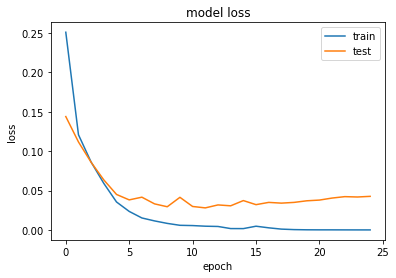

In [14]:
import matplotlib.pyplot as plt
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [15]:
with open('../input/smart-reply-sentence-similarity-using-annoy/target_texts.pickle', 'rb') as handle:
    target_texts = pickle.load(handle)

In [16]:
predictions = model.predict_classes(predictors, verbose=0)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [17]:
predictors

array([[   0,    0,    0, ...,  224,   11, 7719],
       [   0,    0,    0, ..., 1162,   10, 1810],
       [   0,    0,    0, ...,    3,  823, 1608],
       ...,
       [   0,    0,    0, ...,   32,   19,    4],
       [   0,    0,    0, ...,  210,  152,  317],
       [   0,    0,    0, ..., 1279,  662,  772]], dtype=int32)

In [18]:
unique, counts = np.unique(predictions, return_counts=True)
print(np.asarray((unique, counts)).T)

[[    0    15]
 [    1    24]
 [    2     7]
 [    3   153]
 [    4     7]
 [    5    20]
 [    6     6]
 [    7     7]
 [    8     5]
 [    9    12]
 [   10     5]
 [   11     7]
 [   12    16]
 [   13    18]
 [   14     5]
 [   15     5]
 [   16    31]
 [   17    17]
 [   18     7]
 [   19     6]
 [   20     6]
 [   21    11]
 [   22    25]
 [   23    11]
 [   24    13]
 [   25     8]
 [   26     7]
 [   27    17]
 [   28     5]
 [   29    21]
 [   30     9]
 [   31    10]
 [   32     6]
 [   33     6]
 [   34    10]
 [   35     7]
 [   36     9]
 [   37     6]
 [   38     5]
 [   39     7]
 [   40     9]
 [   41     5]
 [   42     5]
 [   43     5]
 [   44    11]
 [   45     6]
 [   46     5]
 [   47     8]
 [   48     9]
 [   49     5]
 [   50     9]
 [   51     7]
 [   52     6]
 [   53     5]
 [   54     5]
 [   55     8]
 [   56     5]
 [   57     6]
 [   58    10]
 [   59    13]
 [   60     5]
 [   61     8]
 [   62 21134]]


In [19]:
np.where(predictions==44)

(array([ 6012,  6609, 11732, 11790, 12332, 13788, 16956, 18011, 18441,
        20282, 20756]),)

In [20]:
def get_responses(seed_text, n):
    print("Input -", seed_text)
    print("----------------------")
    responses = set()
    while len(responses) < n:
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = tf.keras.preprocessing.sequence.pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted_index = model.predict_classes(token_list, verbose=0)
        # print(predicted_index)
        if predicted_index[0] == len(set(dbscan.labels_)) - 1:
            print("Predicting outside clusters")
            predicted_index = -1

        # randomly pick 1 index
        possible_response = np.where(dbscan.labels_==predicted_index)[0]
        response_index = random.sample(possible_response.tolist(), 1)[0]
        # print(response_index)
        responses.add(target_texts[response_index].replace("\t", "").replace("\n", ""))
        
    for i, response in enumerate(responses):
        print("Response", (i + 1), "->", response)

In [21]:
get_responses("goodbye", 5)

Input - goodbye
----------------------
Predicting outside clusters
Predicting outside clusters
Predicting outside clusters
Predicting outside clusters
Predicting outside clusters
Response 1 -> no i had no idea. cool.
Response 2 -> apparently it is 13 but differs by local laws.
Response 3 -> i like green eggs and ham.
Response 4 -> bye.
Response 5 -> i know. too bad the duel is outlawed.


In [22]:
get_responses(input_texts[387], 5)

Input - hi how are you
----------------------
Response 1 -> fine. what about you
Response 2 -> good thanks how are you
Response 3 -> i'm great. do you like dogs
Response 4 -> great. you do you like television
Response 5 -> hey. i'm doing well how are you today


In [23]:
get_responses(input_texts[2985], 5)

Input - have a good night.
----------------------
Response 1 -> bye...
Response 2 -> thanks.
Response 3 -> thanks you as well.
Response 4 -> signing off.
Response 5 -> bye.


In [24]:
get_responses(input_texts[13788], 5)

Input - do you like tv
----------------------
Response 1 -> i do like it and have a passing familiarity
Response 2 -> love it i actually like both football and basketball
Response 3 -> i love it. have you ever seen space jam
Response 4 -> hi yes i do. my favorite are animation movies.
Response 5 -> yes especially watching the nba finals. cavs. vs. warriors.


In [25]:
get_responses("do you like movies", 5)

Input - do you like movies
----------------------
Response 1 -> yes. i am a knick fan
Response 2 -> i do like it and have a passing familiarity
Response 3 -> i love it.do you know who kareem jabbar is
Response 4 -> yes i do. do you like movies
Response 5 -> i do. do you


In [26]:
get_responses("how are you", 5)

Input - how are you
----------------------
Predicting outside clusters
Predicting outside clusters
Predicting outside clusters
Predicting outside clusters
Predicting outside clusters
Response 1 -> bad decision. nice chatting with you
Response 2 -> yes the website that displays secrets of the government
Response 3 -> i did a long time ago. did you
Response 4 -> lol. that one might not go on facebook.
Response 5 -> the simpsons is always making fun of them.


In [27]:
get_responses("goodmorning", 5)

Input - goodmorning
----------------------
Response 1 -> it was actually edgar allen poe.
Response 2 -> i dont really know wrestling. do you like it
Response 3 -> i have but in name and murder only. you
Response 4 -> no never. anything interesting about it.
Response 5 -> bye.
